In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


#### IMPORTING LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
import re
import string
import pickle
import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install wordcloud
import wordcloud
from wordcloud import WordCloud

In [4]:
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [5]:
#importing stopwords list
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### IMPORTING DATASET

In [6]:
dataset = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', header = 0, encoding = 'Latin', engine = 'python')
cols = ['sentiment', 'id', 'date', 'query', 'user','tweet']
dataset.columns = cols
dataset.head()

,sentiment,id,date,query,user,tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [7]:
dataset.tail()

,sentiment,id,date,query,user,tweet
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


#### REDUNDANT DATA REMOVAL

In [8]:
data = dataset
data = data.drop(['id', 'date', 'query', 'user'], axis = 1)
data.head()

,sentiment,tweet
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


#### EXPLORATORY ANALYSIS

In [9]:
data.describe()

,sentiment
count,1.599999e+06
mean,2.000001e+00
std,2.000001e+00
min,0.000000e+00
25%,0.000000e+00
50%,4.000000e+00
75%,4.000000e+00
max,4.000000e+00


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1599999 non-null  int64 
 1   tweet      1599999 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [11]:
data['sentiment'].unique()

array([0, 4])

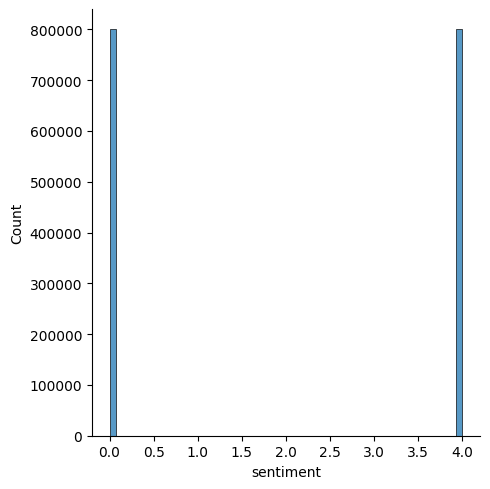

In [12]:
sns.displot(data['sentiment'])

#### DATA PREPROCESSING

In [13]:
#Dataset Reduction
limit = 400000
negatives = data[0:limit]
positives = data[800000:(800000 + limit)]
working_data = pd.concat([negatives, positives])

In [14]:
working_data['sentiment'][working_data['sentiment']== 4] = 1
working_data['sentiment'][working_data['sentiment']== 0] = 0

In [15]:
working_data.head()

,sentiment,tweet
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [16]:
working_data.tail()

,sentiment,tweet
1199995,1,Finding life's simple delights in the midst of...
1199996,1,@McLovin143 just tell me when your on your wa...
1199997,1,goodbye downtown
1199998,1,everyone should watch mtv hits rn. its everyon...
1199999,1,danielle is the best thing since cheese in a c...


In [17]:
working_data.shape

(800000, 2)

In [18]:
def preprocess_data (input):
    
    #stopword removal
    input = " ".join([word for word in str(input).split() if word not in stop_words])
    
    #converting to lower case
    input = input.lower()
    
    #url removal
    input = re.sub(r"http\S+|www\S+|https\S+","",input,flags = re.MULTILINE)
    
    #punction removal
    input = input.translate(str.maketrans("", "", string.punctuation))
                        
    #repeated character removal
    input = re.sub(r'(.)\1+', r'\1', input)
                        
    #numerical character removal
    input = re.sub('[0-9]+', '', input)
    
    #removing user@ references and #
    input = re.sub(r'\@\w+|\#w+', "", input)
                     
    #tokenization
    tokens = RegexpTokenizer(r'\w+')
    filtered_list = tokens.tokenize(input)
    
    #stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(w) for w in filtered_list]
      
    #lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos = 'a') for w in stemmed_words]
    
    #output
    return " ".join(lemma_words)

In [19]:
input = " True that. Absolutely bad bad movie, would not rate it more than 5/10. @Theodor #HNY"
preprocess_data (input)

'true that absolut bad bad movi would rate theodor hni'

In [20]:
working_data['tweet'] = working_data['tweet'].apply(lambda x : preprocess_data(x))
gc.collect()

128

In [21]:
working_data.head()

,sentiment,tweet
0,0,upset cant updat facebok text it might cri res...
1,0,kenichan i dive mani time bal manag save the r...
2,0,whole bodi fel itchi like fire
3,0,nationwidecla no behav al im mad here i cant s...
4,0,kwesidei whole crew


In [22]:
working_data.tail()

,sentiment,tweet
1199995,1,find life simpl delight midst heal brain chang
1199996,1,mclovin tel way il kep check twiter
1199997,1,godby downtown
1199998,1,everyon watch mtv hit rn everyon bnd
1199999,1,daniel best thing sinc chese can


#### PROCEED DATA VISUALIZATION

##### POSITIVE SENTIMENTS

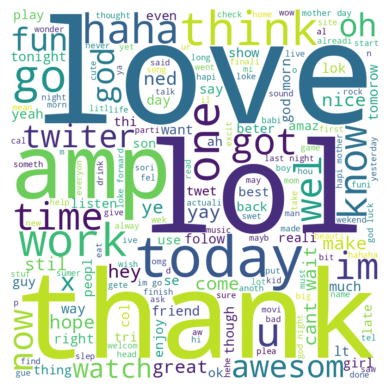

0

In [23]:
text_positive = " ".join(tweet for tweet in working_data['tweet'][working_data['sentiment']==1])
positive_wordcloud = WordCloud(width = 800, height = 800, background_color ='white',max_words = 1000, min_font_size = 15).generate(text_positive)
plt.imshow(positive_wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()
positive_wordcloud.to_file('/kaggle/working/positive_word.png')
gc.collect()

##### NEGATIVE SENTIMENTS

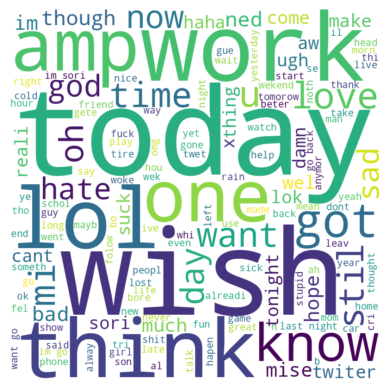

2126

In [24]:
text_negative = " ".join(tweet for tweet in working_data['tweet'][working_data['sentiment']==0])
negative_wordcloud = WordCloud(width = 800, height = 800, background_color ='white',max_words = 1000, min_font_size = 15).generate(text_negative)
plt.imshow(negative_wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()
negative_wordcloud.to_file('/kaggle/working/negative_word.png')
gc.collect()

#### PROCESSED TWEET VECTORIZATION

In [25]:
verctorizer = TfidfVectorizer()
X = (working_data['tweet'])
Y = (working_data['sentiment'])
X = verctorizer.fit_transform(X)
gc.collect()

0

In [26]:
X

<800000x368963 sparse matrix of type '<class 'numpy.float64'>'
	with 6279599 stored elements in Compressed Sparse Row format>

In [27]:
Y

0          0
1          0
2          0
3          0
4          0
          ..
1199995    1
1199996    1
1199997    1
1199998    1
1199999    1
Name: sentiment, Length: 800000, dtype: int64

#### HYPERPARAMETER TUNING

In [28]:
random_state_limit = 20
accuracies = []

for i in range(random_state_limit + 1):
    x_train, x_test, y_train, y_test = train_test_split (X, Y, test_size = 0.15,shuffle = True, stratify = Y, random_state = i)
    x_train = x_train.toarray()
    x_test = x_test.toarray()
    test_model = LogisticRegression(max_iter = 5)
    test_model.fit(x_train, y_train)
    y_predict = test_model.predict(x_test)
    score = accuracy_score(y_test,y_predict)*100
    accuracies.append(score)
    gc.collect()
    
accuracies = np.array(accuracies)
gc.collect()

0

In [29]:
best_score = np.max(accuracies)
best_random_state = np.argmax(accuracies)
print('Best Score : ' + str(best_score))
print('Best Random State : ' + str(best_random_state))
gc.collect()

Best Score : 72.02833333333334
Best Random State : 17


0

#### TRAIN TEST SPLIT

In [30]:
x_train, x_test, y_train, y_test = train_test_split (X, Y, test_size = 0.15,shuffle = True, stratify = Y, random_state = int(best_random_state))

In [31]:
x_train = x_train.toarray()
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
y_train

864561     1
982105     1
912018     1
237325     0
1009916    1
          ..
260045     0
256775     0
1006204    1
802539     1
1076586    1
Name: sentiment, Length: 680000, dtype: int64

In [33]:
x_test = x_test.toarray()
x_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
y_test

809802     1
1036057    1
939692     1
1100239    1
848413     1
          ..
119023     0
320052     0
326779     0
1105499    1
342345     0
Name: sentiment, Length: 120000, dtype: int64

#### MODEL IMPLEMENTATION

In [35]:
setiment_model = LogisticRegression(max_iter = 100)
setiment_model.fit(x_train, y_train)

LogisticRegression()

#### MODEL EVALUATION

In [36]:
y_predict = setiment_model.predict(x_test)

In [37]:
print('The classification test results are : \n')
print(classification_report(y_test,y_predict))
print('Confusion Matrix :')
cm=confusion_matrix(y_test,y_predict)
print(cm)
print('\n')
print('The test accuracy percentage is :')
print((accuracy_score(y_test,y_predict))*100)
print('\n')
print('The test precision percentage is :')
print((precision_score(y_test,y_predict))*100)
print('\n')
print('The test recall percentage is :')
print((recall_score(y_test,y_predict))*100)
print('\n')
print('The test f1 percentage is :')
print((f1_score(y_test,y_predict))*100)
print('\n')
print('The test ROC AUC score is :')
print(roc_auc_score(y_test,y_predict))

The classification test results are : 

              precision    recall  f1-score   support

           0       0.80      0.76      0.78     60000
           1       0.77      0.81      0.79     60000

    accuracy                           0.78    120000
   macro avg       0.78      0.78      0.78    120000
weighted avg       0.78      0.78      0.78    120000

Confusion Matrix :
[[45300 14700]
 [11552 48448]]


The test accuracy percentage is :
78.12333333333333


The test precision percentage is :
76.72135301197187


The test recall percentage is :
80.74666666666667


The test f1 percentage is :
78.6825608211258


The test ROC AUC score is :
0.7812333333333333


#### SAVING THE OUTPUTS

In [38]:
pickle.dump(verctorizer, open('/kaggle/working/vectorizer.pkl','wb'))
pickle.dump(setiment_model, open('/kaggle/working/setiment_model.pkl','wb'))